# Far Detuned Lattice Transport simulations

Santi

15 January 2026

The goal here is to simulate the results from this paper (https://journals.aps.org/pra/abstract/10.1103/PhysRevA.109.023321) and change the parameters to see how it would be impacted in our setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ARC (install with: pip install ARC-Alkali-Rydberg-Calculator)
from arc import PairStateInteractions, AlkaliAtom  # species and interactions'
# import all the atoms we might use
from arc import Sodium, Cesium, Rubidium, Potassium

from get_polarizability import *

In [10]:
# constants
h = 6.62607015e-34  # Planck's constant in J*s
hbar = h / (2 * np.pi)  # reduced Planck's constant
c = 299792458  # speed of light in m/s
epsilon_0 = 8.854187817e-12  # vacuum permittivity in F/m
a0 = 5.29177210903e-11  # Bohr radius in meters
e = 1.602176634e-19  # elementary charge in Coulombs
me = 9.10938356e-31  # electron mass in kg
kB = 1.380649e-23  # Boltzmann constant in J/K

wavelength = 1064e-9  # lattice wavelength in meters

alpha_Cs = get_polarizability(wavelength*1e9, "Cs") * a0**3  # Cs polarizability in atomic units
alpha_Rb = get_polarizability(wavelength*1e9, "Rb") * a0**3   # Rb polarizability in atomic units

# convert polarizability from atomic units to SI units
alpha_Cs_SI = alpha_Cs * 4*np.pi * epsilon_0
alpha_Rb_SI = alpha_Rb * 4*np.pi * epsilon_0

print(f"Cs polarizability at {wavelength*1e9} nm: {alpha_Cs/a0**3:.2f} a0^3")
print(f"Rb polarizability at {wavelength*1e9} nm: {alpha_Rb/a0**3:.2f} a0^3")

Cs polarizability at 1064.0 nm: 1167.50 a0^3
Rb polarizability at 1064.0 nm: 687.40 a0^3


## Reproduce paper results first

In [4]:
def odt_depth(I, alpha):
    """ calculate ODT depth in Kelvin"""
    U = -0.5 * alpha * I / (c * epsilon_0)  # in Joules
    return -U / kB

def Gaussian_beam_size(w0, x, xf, xR):
    """ calculate Gaussian beam size at position x"""
    w_x = w0 * np.sqrt(1 + ((x - xf)/ xR)**2)
    # # plot beam size as a function of distance from focus
    # plt.figure()
    # plt.plot(x - xf, w_x, 'k-', label='Beam Size')
    # plt.xlabel('Distance from Focus (m)')
    # plt.ylabel('Beam Size (m)')
    # plt.axvline(x=0, color='r', linestyle='--', label='Focus Position')
    # plt.legend()
    # plt.show()
    return w_x

def Gaussian_beam_peak_intensity(P, w, xf, x):
    """ calculate Gaussian beam peak intensity with beam size w"""
    intensity = 2 * P / (np.pi * w**2) # peak intensity
    # # plot intensity profile
    # plt.figure()
    # plt.plot(x, intensity, 'k-', label='Intensity Profile')
    # plt.xlabel('Position (m)')
    # plt.ylabel('Intensity (W/m^2)')
    # plt.axvline(x=xf, color='r', linestyle='--', label='Focus Position')
    # plt.legend()
    # plt.show()
    return intensity

def Gaussian_beam_intensity(P, w0, pos_array, xf):
    """ calculate Gaussian beam intensity as a function of x,y,z focused at a point xf"""
    xR = np.pi * w0**2 / wavelength  # Rayleigh range
    w_x = Gaussian_beam_size(w0, pos_array[0], xf, xR) # position dependent beam size
    I_xyz = Gaussian_beam_peak_intensity(P, w_x, xf, pos_array[0]) * np.exp(-2 * (pos_array[1]**2 + pos_array[2]**2) / w_x**2)
    return I_xyz

def two_beam_lattice_intensity(P, w0, pos_array, focus1, focus2):
    """ calculate two-beam lattice intensity as a function of x,y,z"""
    I1 = Gaussian_beam_intensity(P, w0, pos_array, focus1)
    I2 = Gaussian_beam_intensity(P, w0, pos_array, focus2)
    I_lattice = I1 + I2 + 2 * np.sqrt(I1 * I2) * np.cos(4 * np.pi * pos_array[0] / wavelength)
    return I_lattice

Plotting the Gaussian beam intensity profile as a sanity check.

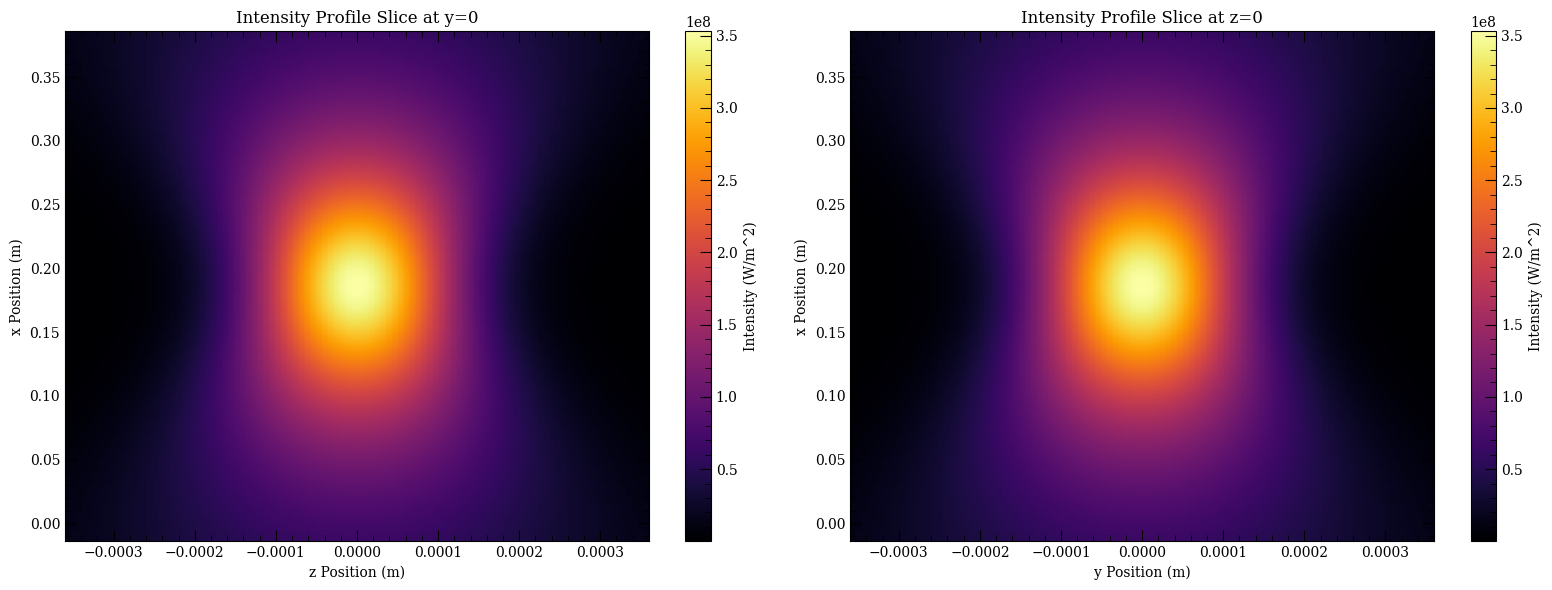

In [5]:
# calculate and visualize the full 3D intensity profile of a single Gaussian beam
power = 18  # power in Watts
waist = 180e-6  # beam waist in meters
focus = 0.186  # focus position in meters
# create a grid of positions in x,y,z
x = np.linspace(focus - 0.2, focus + 0.2, 200)
y = np.linspace(-2*waist, 2*waist, 100)
z = np.linspace(-2*waist, 2*waist, 100)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
pos_array = np.array((X.flatten(), Y.flatten(), Z.flatten()))
# calculate the intensity profile
I_profile = Gaussian_beam_intensity(power, waist, pos_array, focus)
I_profile = I_profile.reshape(X.shape)
# visualize a slice of the intensity profile at y=0 along z and z=0 along y side by side
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.imshow(I_profile[:, I_profile.shape[1]//2, :], extent=(z[0], z[-1], x[0], x[-1]), aspect='auto', origin='lower', cmap='inferno')
plt.colorbar(label='Intensity (W/m^2)')
plt.xlabel('z Position (m)')
plt.ylabel('x Position (m)')
plt.title('Intensity Profile Slice at y=0')
plt.subplot(1, 2, 2)
plt.imshow(I_profile[:, :, I_profile.shape[2]//2], extent=(y[0], y[-1], x[0], x[-1]), aspect='auto', origin='lower', cmap='inferno')
plt.colorbar(label='Intensity (W/m^2)')
plt.xlabel('y Position (m)')
plt.ylabel('x Position (m)')
plt.title('Intensity Profile Slice at z=0')
plt.tight_layout()
plt.show()

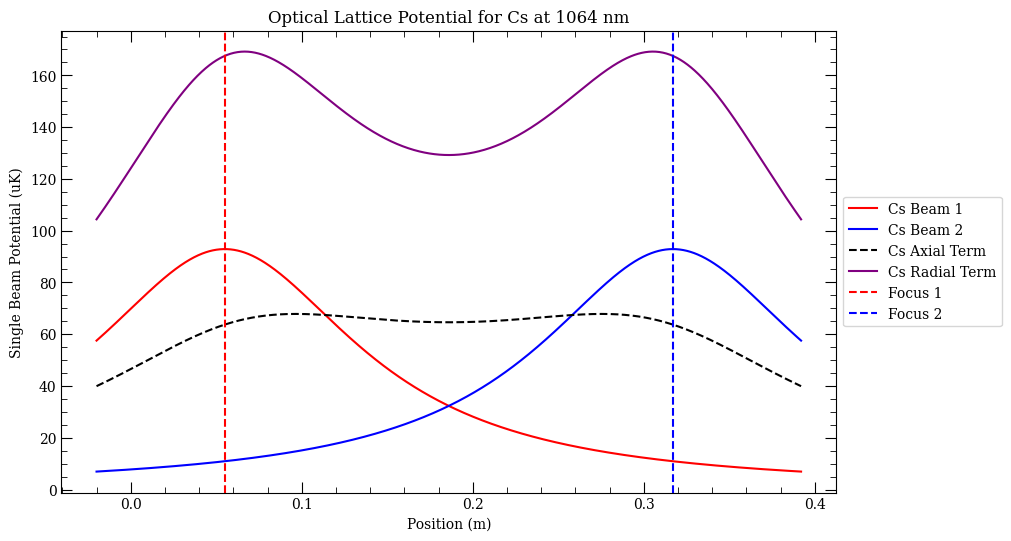

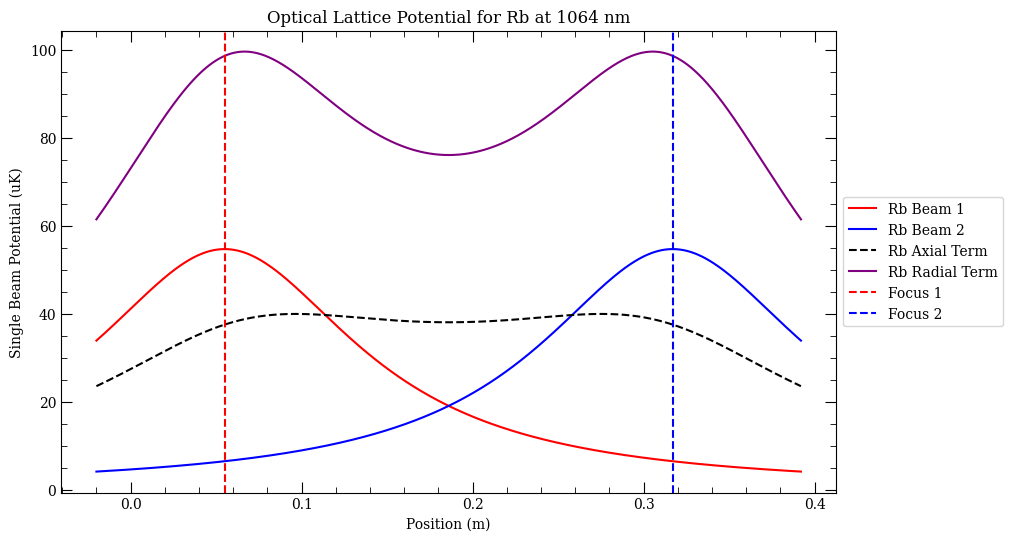

In [6]:
power = 18 # power per beam in Watts
waist = 180e-6 # beam waist in meters
focus1 = 0.055
focus2 = 0.372-0.055

pos_array = np.array((np.linspace(focus1 - 0.075, focus2 + 0.075, 1000),   # x positions
                    np.zeros(1000),  # y positions
                    np.zeros(1000))) # z positions

I1 = Gaussian_beam_intensity(power, waist, pos_array, focus1)
I2 = Gaussian_beam_intensity(power, waist, pos_array, focus2)

# first calculate the potential created by each beam separately
U1_Cs = odt_depth(I1, alpha_Cs_SI) * 1e6  # convert to uK
U2_Cs = odt_depth(I2, alpha_Cs_SI) * 1e6  # convert to uK
# calculate the cross term potential (axial)
U_cross_Cs = odt_depth(np.sqrt(I1*I2), alpha_Cs_SI) * 1e6  # convert to uK
# calculate the radial potential
U_radial_Cs = odt_depth(I1+I2+2*np.sqrt(I1*I2), alpha_Cs_SI) * 1e6  # convert to uK

plt.figure(figsize=(10, 6))
plt.plot(pos_array[0], U1_Cs, 'r-', label='Cs Beam 1')
plt.plot(pos_array[0], U2_Cs, 'b-', label='Cs Beam 2')
plt.plot(pos_array[0], 2*U_cross_Cs, 'k--', label='Cs Axial Term')
plt.plot(pos_array[0], U_radial_Cs, 'purple', label='Cs Radial Term')
# plot the positions of the foci
plt.axvline(focus1, color='red', linestyle='--', label='Focus 1')
plt.axvline(focus2, color='blue', linestyle='--', label='Focus 2')
plt.xlabel('Position (m)')
plt.ylabel('Single Beam Potential (uK)')
# put legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Optical Lattice Potential for Cs at 1064 nm')
plt.show()


# repeat for Rb
U1_Rb = odt_depth(I1, alpha_Rb_SI) * 1e6  # convert to uK
U2_Rb = odt_depth(I2, alpha_Rb_SI) * 1e6  # convert to uK
# calculate the cross term potential (axial)
U_cross_Rb = odt_depth(np.sqrt(I1*I2), alpha_Rb_SI) * 1e6  # convert to uK
# calculate the radial potential
U_radial_Rb = odt_depth(I1+I2+2*np.sqrt(I1*I2), alpha_Rb_SI) * 1e6  # convert to uK

plt.figure(figsize=(10, 6))
plt.plot(pos_array[0], U1_Rb, 'r-', label='Rb Beam 1')
plt.plot(pos_array[0], U2_Rb, 'b-', label='Rb Beam 2')
plt.plot(pos_array[0], 2*U_cross_Rb, 'k--', label='Rb Axial Term')
plt.plot(pos_array[0], U_radial_Rb, 'purple', label='Rb Radial Term')
# plot the positions of the foci
plt.axvline(focus1, color='red', linestyle='--', label='Focus 1')
plt.axvline(focus2, color='blue', linestyle='--', label='Focus 2')
plt.xlabel('Position (m)')
plt.ylabel('Single Beam Potential (uK)')
# put legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Optical Lattice Potential for Rb at 1064 nm')
plt.show()

Looking at the potential as a 2D heat map along the axes. I believe this plot has the correct form compared to the paper.

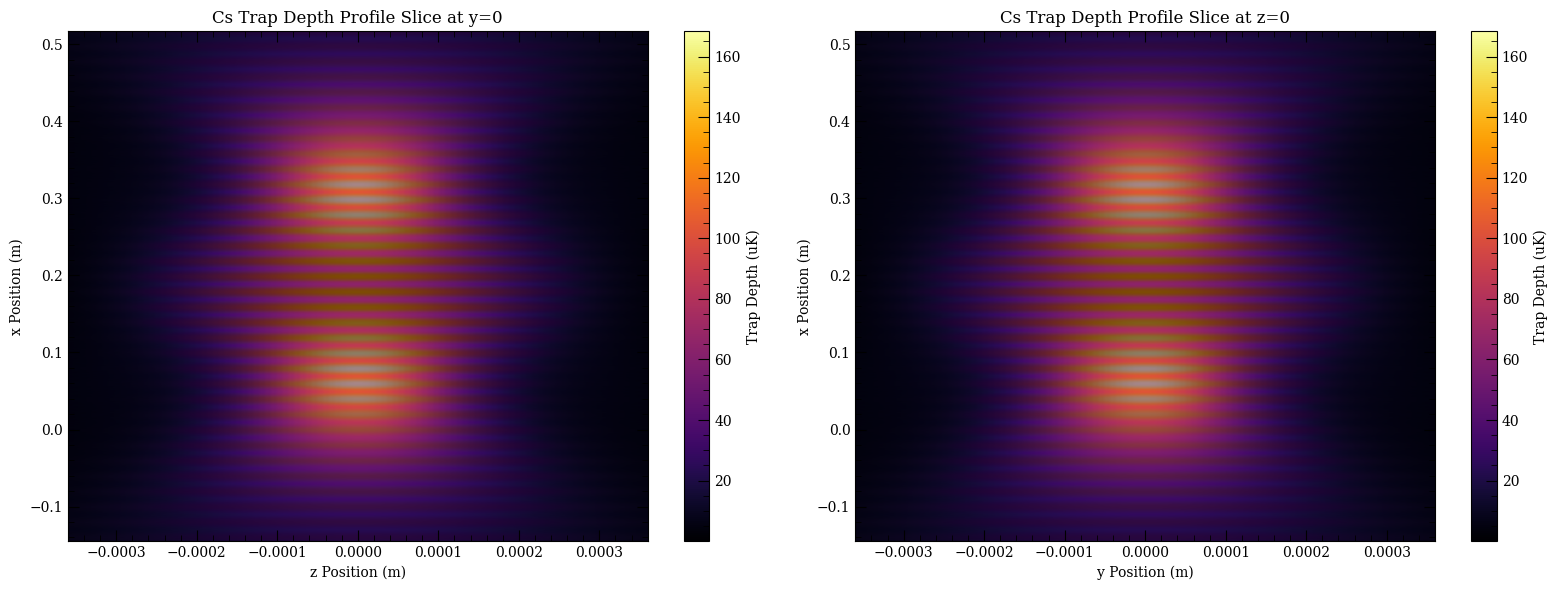

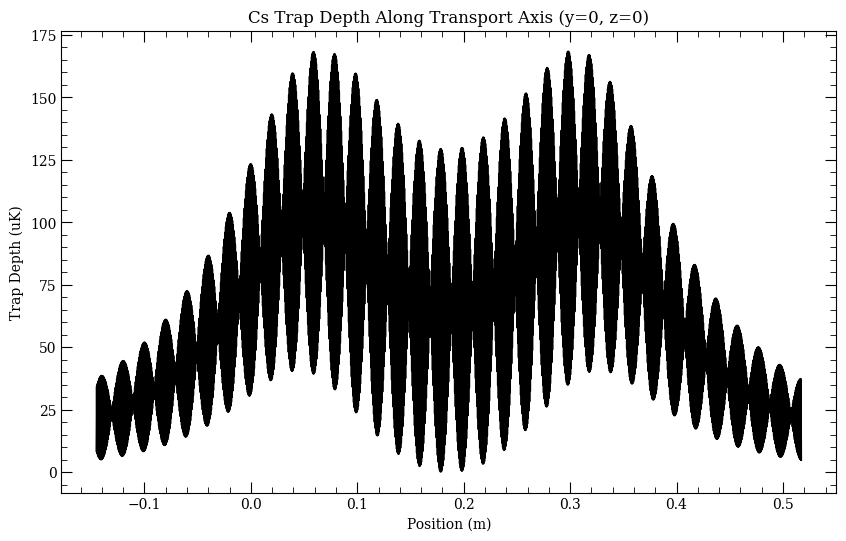

In [7]:
# plot the Cs axial trap potential as a full 3D profile similar to above for Gaussian beam
power = 18  # power in Watts
waist = 180e-6  # beam waist in meters
focus1 = 0.055
focus2 = 0.372-0.055
# create a grid of positions in x,y,z
x = np.linspace(focus1 - 0.2, focus2 + 0.2, 2000)
y = np.linspace(-2*waist, 2*waist, 100)
z = np.linspace(-2*waist, 2*waist, 100)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
pos_array = np.array((X.flatten(), Y.flatten(), Z.flatten()))
# calculate the intensity profile
I_profile = two_beam_lattice_intensity(power, waist, pos_array, focus1, focus2)
U_profile_Cs = odt_depth(I_profile, alpha_Cs_SI) * 1e6  # convert to uK
U_profile_Cs = U_profile_Cs.reshape(X.shape)
# visualize a slice of the potential profile at y=0 for z and then z=0 for y side by side
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.imshow(U_profile_Cs[:, U_profile_Cs.shape[1]//2, :], extent=(z[0], z[-1], x[0], x[-1]), aspect='auto', origin='lower', cmap='inferno')
plt.colorbar(label='Trap Depth (uK)')
plt.xlabel('z Position (m)')
plt.ylabel('x Position (m)')
plt.title('Cs Trap Depth Profile Slice at y=0')
plt.subplot(1, 2, 2)
plt.imshow(U_profile_Cs[:, :, U_profile_Cs.shape[2]//2], extent=(y[0], y[-1], x[0], x[-1]), aspect='auto', origin='lower', cmap='inferno')
plt.colorbar(label='Trap Depth (uK)')
plt.xlabel('y Position (m)')
plt.ylabel('x Position (m)')
plt.title('Cs Trap Depth Profile Slice at z=0')
plt.tight_layout()
plt.show()

# plot a cut along the transport axis at y=0, z=0
plt.figure(figsize=(10, 6))
plt.plot(x, U_profile_Cs[:, U_profile_Cs.shape[1]//2, U_profile_Cs.shape[2]//2], 'k-')
plt.xlabel('Position (m)')
plt.ylabel('Trap Depth (uK)')
plt.title('Cs Trap Depth Along Transport Axis (y=0, z=0)')
plt.show()

Optimal parameters for Cs: Waist = 178.56 microns, Focus = 0.0529 m, Max Trap Depth = 125.25 uK
Optimal parameters for Rb: Waist = 178.56 microns, Focus = 0.0529 m, Max Trap Depth = 74.05 uK


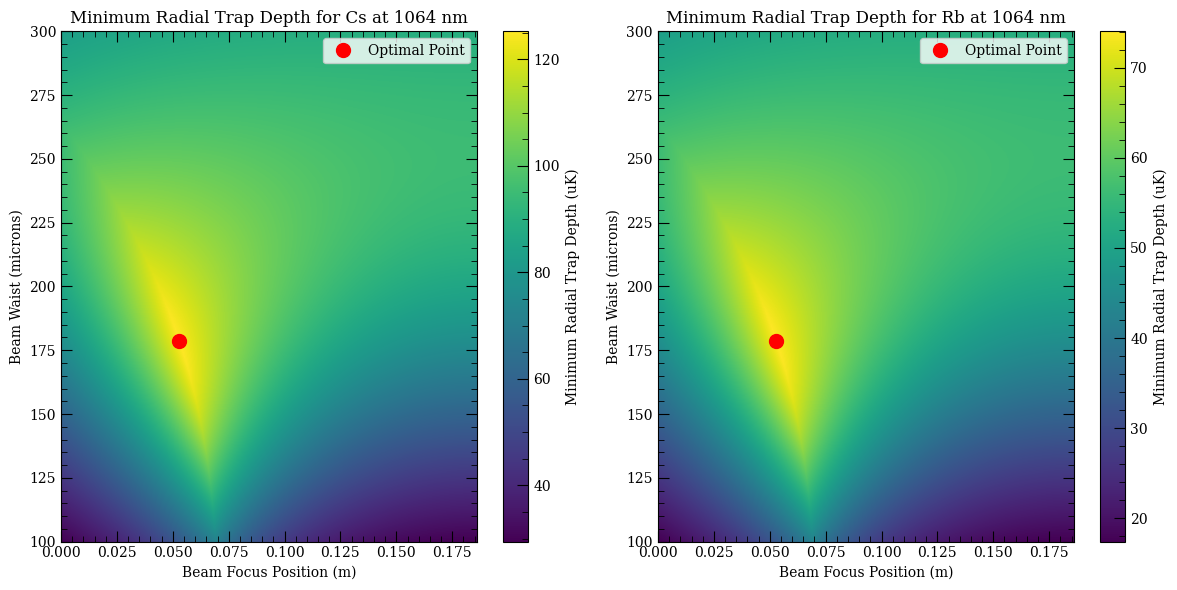

In [74]:
# now 2D sweep of beam waist and beam focus positions
# the start and stop of the atoms is always 0.0 and 0.372
# the focus positions will always be symmetric around the center point 0.186
start_pos = 0.0
stop_pos = 0.372
center_pos = (start_pos + stop_pos) / 2
focus_array = np.linspace(0.0, center_pos, 500)  # focus positions from 0 to center position

waist_array = np.linspace(100e-6, 300e-6, 500)  # beam waist from 100 to 300 microns

# for the sweep, we find the minimum radial trap depth between the start and stop positions
min_trap_depth_Cs = []
min_trap_depth_Rb = []

pos_array = np.array((np.linspace(start_pos, stop_pos, 1000),   # x positions
                    np.zeros(1000),  # y positions
                    np.zeros(1000))) # z positions

for waist in waist_array:
    temp_depths_Cs = []
    temp_depths_Rb = []
    for focus in focus_array:
        # calculate the intensity for each beam
        I1 = Gaussian_beam_intensity(power, waist, pos_array, focus)
        I2 = Gaussian_beam_intensity(power, waist, pos_array, stop_pos - focus)

        # calculate the optical radial trap depth for each beam
        depth_Cs = odt_depth(I1+I2+2*np.sqrt(I1*I2), alpha_Cs_SI) * 1e6  # convert to uK
        depth_Rb = odt_depth(I1+I2+2*np.sqrt(I1*I2), alpha_Rb_SI) * 1e6  # convert to uK

        # find the minimum radial trap depth for each beam
        min_depth_Cs = np.min(depth_Cs)
        min_depth_Rb = np.min(depth_Rb)

        temp_depths_Cs.append(min_depth_Cs)
        temp_depths_Rb.append(min_depth_Rb)

    # find the minimum trap depth
    min_trap_depth_Cs.append(temp_depths_Cs)
    min_trap_depth_Rb.append(temp_depths_Rb)

# find the optimal parameters for maximum trap depth from above data
min_trap_depth_Cs = np.array(min_trap_depth_Cs)
min_trap_depth_Rb = np.array(min_trap_depth_Rb)

opt_params_Cs = np.unravel_index(np.argmax(min_trap_depth_Cs, axis=None), min_trap_depth_Cs.shape)
opt_params_Rb = np.unravel_index(np.argmax(min_trap_depth_Rb, axis=None), min_trap_depth_Rb.shape)

print(f"Optimal parameters for Cs: Waist = {waist_array[opt_params_Cs[0]]*1e6:.2f} microns, Focus = {focus_array[opt_params_Cs[1]]:.4f} m, Max Trap Depth = {min_trap_depth_Cs[opt_params_Cs]:.2f} uK")
print(f"Optimal parameters for Rb: Waist = {waist_array[opt_params_Rb[0]]*1e6:.2f} microns, Focus = {focus_array[opt_params_Rb[1]]:.4f} m, Max Trap Depth = {min_trap_depth_Rb[opt_params_Rb]:.2f} uK")

# plot the results as a heatmap
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(min_trap_depth_Cs, extent=(focus_array[0], focus_array[-1], waist_array[0]*1e6, waist_array[-1]*1e6), aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Minimum Radial Trap Depth (uK)')
plt.ylabel('Beam Waist (microns)')
plt.xlabel('Beam Focus Position (m)')
plt.title('Minimum Radial Trap Depth for Cs at 1064 nm')
# put a red dot at the optimal waist and focus
plt.plot(focus_array[opt_params_Cs[1]], waist_array[opt_params_Cs[0]]*1e6, 'ro', markersize=10, label='Optimal Point')
plt.legend()
plt.subplot(1, 2, 2)
plt.imshow(min_trap_depth_Rb, extent=(focus_array[0], focus_array[-1], waist_array[0]*1e6, waist_array[-1]*1e6), aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Minimum Radial Trap Depth (uK)')
plt.ylabel('Beam Waist (microns)')
plt.xlabel('Beam Focus Position (m)')
plt.title('Minimum Radial Trap Depth for Rb at 1064 nm')
# put a red dot at the optimal waist and focus
plt.plot(focus_array[opt_params_Rb[1]], waist_array[opt_params_Rb[0]]*1e6, 'ro', markersize=10, label='Optimal Point')
plt.legend()
plt.tight_layout()
plt.show()

## optimal minimum trap depth as a function of distance transport

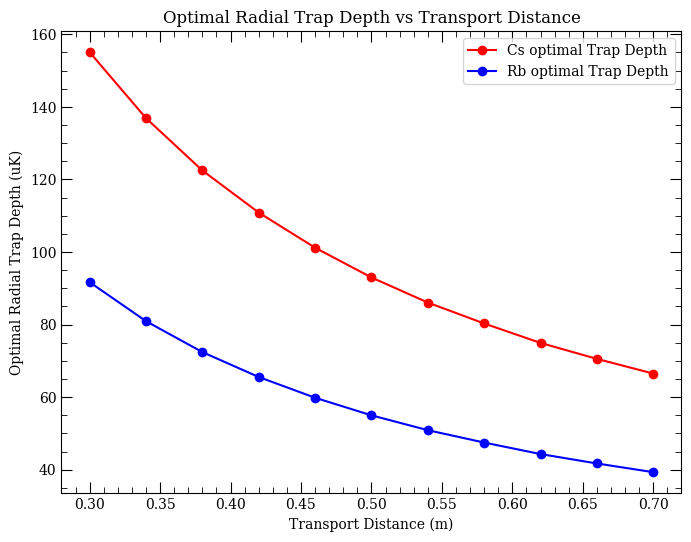

In [79]:
# perform the same optimization as above but now sweep over the transport distance as well

transport_distances = np.linspace(0.3, 0.7, 11)  # transport distances
rb_data_array = []
cs_data_array = []
optimal_waists_Cs = []
optimal_focuses_Cs = []
optimal_waists_Rb = []
optimal_focuses_Rb = []
all_focus_arrays = []
all_waist_arrays = []
for dist in transport_distances:
    # now 2D sweep of beam waist and beam focus positions
    # the start and stop of the atoms is always 0.0 and dist
    # the focus positions will always be symmetric around the center point dist/2
    start_pos = 0.0
    stop_pos = dist
    center_pos = (start_pos + stop_pos) / 2
    focus_array = np.linspace(0.0, center_pos, 100)  # focus positions from 0 to center position
    waist_array = np.linspace(100e-6, 400e-6, 100)  # beam waist from 100 to 400 microns
    all_focus_arrays.append(focus_array)
    all_waist_arrays.append(waist_array)
    
    # for the sweep, we find the minimum radial trap depth between the start and stop positions
    min_trap_depth_Cs = []
    min_trap_depth_Rb = []

    pos_array = np.array((np.linspace(start_pos, stop_pos, 1000),   # x positions
                        np.zeros(1000),  # y positions
                        np.zeros(1000))) # z positions

    for waist in waist_array:
        temp_depths_Cs = []
        temp_depths_Rb = []
        for focus in focus_array:
            # calculate the intensity for each beam
            I1 = Gaussian_beam_intensity(power, waist, pos_array, focus)
            I2 = Gaussian_beam_intensity(power, waist, pos_array, stop_pos - focus)

            # calculate the optical radial trap depth for each beam
            depth_Cs = odt_depth(I1+I2+2*np.sqrt(I1*I2), alpha_Cs_SI) * 1e6  # convert to uK
            depth_Rb = odt_depth(I1+I2+2*np.sqrt(I1*I2), alpha_Rb_SI) * 1e6  # convert to uK

            # find the minimum radial trap depth for each beam
            min_depth_Cs = np.min(depth_Cs)
            min_depth_Rb = np.min(depth_Rb)

            temp_depths_Cs.append(min_depth_Cs)
            temp_depths_Rb.append(min_depth_Rb)

        # find the minimum trap depth
        min_trap_depth_Cs.append(temp_depths_Cs)
        min_trap_depth_Rb.append(temp_depths_Rb)

    cs_data_array.append(min_trap_depth_Cs)
    rb_data_array.append(min_trap_depth_Rb)

    # find optimal parameters for maximum trap depth from above data
    min_trap_depth_Cs = np.array(min_trap_depth_Cs)
    min_trap_depth_Rb = np.array(min_trap_depth_Rb)

    # find optimal parameters for maximum trap depth
    opt_params_Cs = np.unravel_index(np.argmax(min_trap_depth_Cs, axis=None), min_trap_depth_Cs.shape)
    opt_params_Rb = np.unravel_index(np.argmax(min_trap_depth_Rb, axis=None), min_trap_depth_Rb.shape)

    optimal_waists_Cs.append(waist_array[opt_params_Cs[0]])
    optimal_focuses_Cs.append(focus_array[opt_params_Cs[1]])

    optimal_waists_Rb.append(waist_array[opt_params_Rb[0]])
    optimal_focuses_Rb.append(focus_array[opt_params_Rb[1]])

# convert to numpy arrays
rb_data_array = np.array(rb_data_array)
cs_data_array = np.array(cs_data_array)

# plot the maximum trap depth as a function of transport distance
max_trap_depths_Cs = [np.max(data) for data in cs_data_array]
max_trap_depths_Rb = [np.max(data) for data in rb_data_array]

plt.figure(figsize=(8, 6))
plt.plot(transport_distances, max_trap_depths_Cs, 'r-o', label='Cs optimal Trap Depth')
plt.plot(transport_distances, max_trap_depths_Rb, 'b-o', label='Rb optimal Trap Depth')
plt.xlabel('Transport Distance (m)')
plt.ylabel('Optimal Radial Trap Depth (uK)')
plt.title('Optimal Radial Trap Depth vs Transport Distance')
plt.legend()
plt.show()

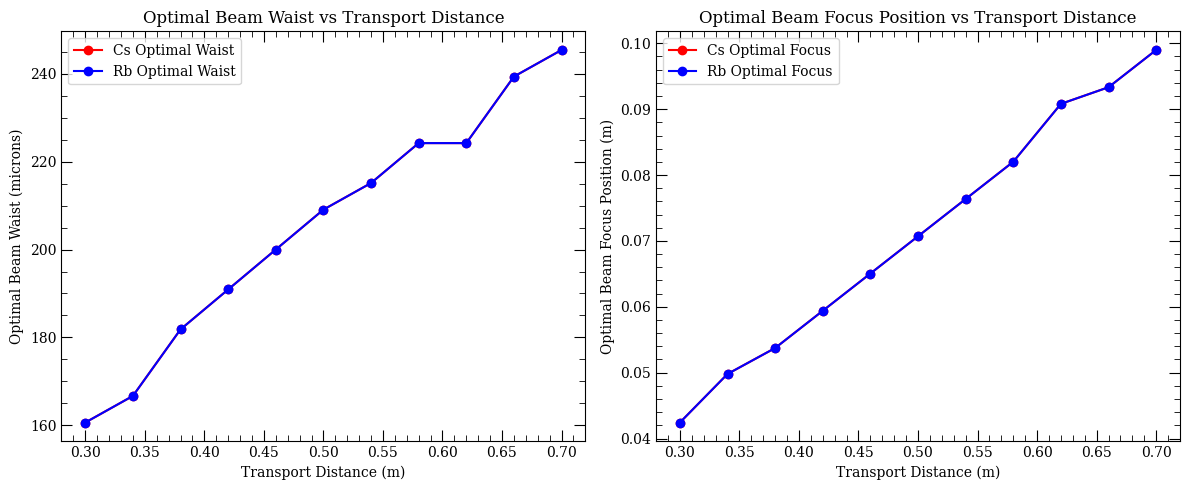

In [80]:
# plot the optimal waist and focus as a function of transport distance from data above
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(transport_distances, np.array(optimal_waists_Cs)*1e6, 'r-o', label='Cs Optimal Waist')
plt.plot(transport_distances, np.array(optimal_waists_Rb)*1e6, 'b-o', label='Rb Optimal Waist')
plt.xlabel('Transport Distance (m)')
plt.ylabel('Optimal Beam Waist (microns)')
plt.title('Optimal Beam Waist vs Transport Distance')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(transport_distances, np.array(optimal_focuses_Cs), 'r-o', label='Cs Optimal Focus')
plt.plot(transport_distances, np.array(optimal_focuses_Rb), 'b-o', label='Rb Optimal Focus')
plt.xlabel('Transport Distance (m)')
plt.ylabel('Optimal Beam Focus Position (m)')
plt.title('Optimal Beam Focus Position vs Transport Distance')
plt.legend()
plt.tight_layout()
plt.show()

At transport distance = 0.50 m:
Optimal parameters for Cs: Waist = 209.09 microns, Focus = 0.0707 m, Max Trap Depth = 92.99 uK
Optimal parameters for Rb: Waist = 209.09 microns, Focus = 0.0707 m, Max Trap Depth = 54.98 uK


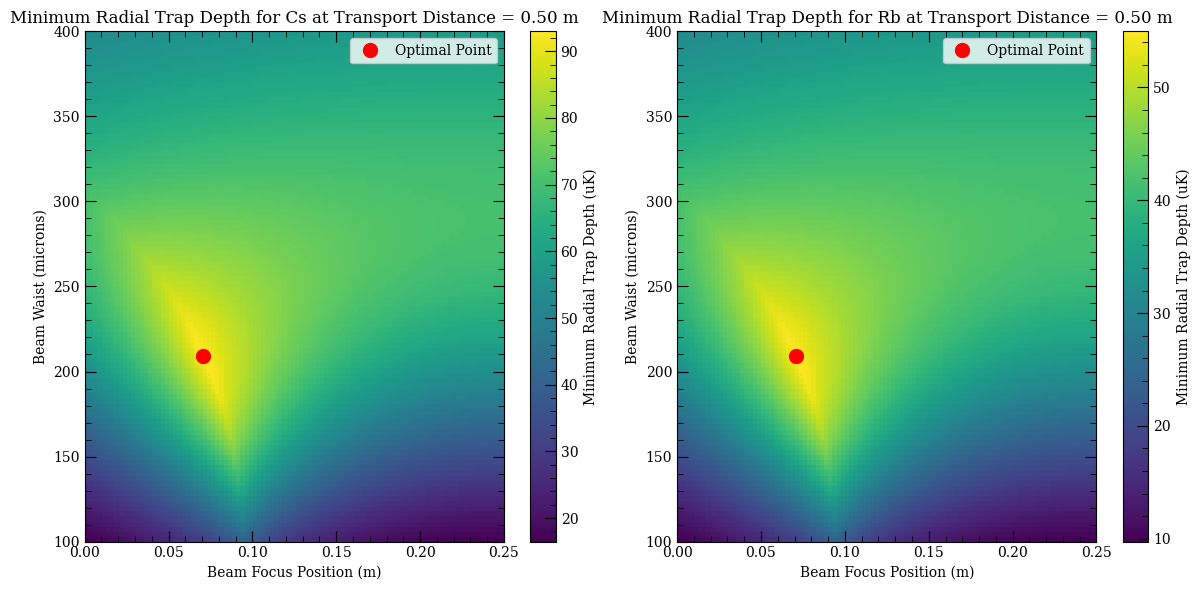

In [81]:
# plot 2D heatmap for a specific transport distance
dist_index = 5  # index of transport distance to plot

# print out the optimal parameters for this distance
print(f"At transport distance = {transport_distances[dist_index]:.2f} m:")
print(f"Optimal parameters for Cs: Waist = {optimal_waists_Cs[dist_index]*1e6:.2f} microns, Focus = {optimal_focuses_Cs[dist_index]:.4f} m, Max Trap Depth = {np.max(cs_data_array[dist_index]):.2f} uK")
print(f"Optimal parameters for Rb: Waist = {optimal_waists_Rb[dist_index]*1e6:.2f} microns, Focus = {optimal_focuses_Rb[dist_index]:.4f} m, Max Trap Depth = {np.max(rb_data_array[dist_index]):.2f} uK")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cs_data_array[dist_index], extent=(all_focus_arrays[dist_index][0], all_focus_arrays[dist_index][-1], all_waist_arrays[dist_index][0]*1e6, all_waist_arrays[dist_index][-1]*1e6), aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Minimum Radial Trap Depth (uK)')
plt.ylabel('Beam Waist (microns)')
plt.xlabel('Beam Focus Position (m)')
plt.title(f'Minimum Radial Trap Depth for Cs at Transport Distance = {transport_distances[dist_index]:.2f} m')
# place a red point at the optimal parameters
opt_waist = optimal_waists_Cs[dist_index] * 1e6
opt_focus = optimal_focuses_Cs[dist_index]
plt.plot(opt_focus, opt_waist, 'ro', markersize=10, label='Optimal Point')
plt.legend()
plt.subplot(1, 2, 2)
plt.imshow(rb_data_array[dist_index], extent=(all_focus_arrays[dist_index][0], all_focus_arrays[dist_index][-1], all_waist_arrays[dist_index][0]*1e6, all_waist_arrays[dist_index][-1]*1e6), aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Minimum Radial Trap Depth (uK)')
plt.ylabel('Beam Waist (microns)')
plt.xlabel('Beam Focus Position (m)')
plt.title(f'Minimum Radial Trap Depth for Rb at Transport Distance = {transport_distances[dist_index]:.2f} m')
# place a red point at the optimal parameters
opt_waist = optimal_waists_Rb[dist_index] * 1e6
opt_focus = optimal_focuses_Rb[dist_index]
plt.plot(opt_focus, opt_waist, 'ro', markersize=10, label='Optimal Point')
plt.legend()
plt.tight_layout()
plt.show()

## Model with gravity.

In [8]:
def radial_trap_depth_vs_x_with_gravity(
    x_array, P, w0, focus1, focus2, wavelength,
    alpha_SI, mass_kg,
    z_max=600e-6, Nz=4001, g=9.80665,
    z_ref=0.0, plot_vertical_pot=False
):
    """
    Compute gravity-reduced radial trap depth along z, as a function of x.

    Returns
    -------
    depth_uK : (Nx,) array
        Radial trap depth (uK) including gravity (escape barrier - min).
    z_min : (Nx,) array
        Sagged z position of the local minimum (m).
    Umin_uK : (Nx,) array
        Potential at the local minimum (uK).
    Ubar_uK : (Nx,) array
        Potential at the downhill barrier (uK). NaN if no barrier found.
    """

    x_array = np.asarray(x_array)
    z = np.linspace(-z_max, z_max, Nz)

    depth_uK = np.zeros_like(x_array, dtype=float)
    z_min = np.full_like(x_array, np.nan, dtype=float)
    Umin_uK = np.full_like(x_array, np.nan, dtype=float)
    Ubar_uK = np.full_like(x_array, np.nan, dtype=float)

    # gravity in uK
    Ug_uK = (mass_kg * g * (z - z_ref) / kB) * 1e6

    # helper: find local min closest to center index using derivative sign change
    def center_local_min_index(y):
        dy = np.diff(y)
        mins = np.where((dy[:-1] < 0) & (dy[1:] > 0))[0] + 1
        if len(mins) == 0:
            return None
        c = len(y) // 2
        return mins[np.argmin(np.abs(mins - c))]

    # helper: find nearest local max on downhill side (gravity pulls toward -z)
    def downhill_local_max_index(y, i_min):
        dy = np.diff(y)
        maxs = np.where((dy[:-1] > 0) & (dy[1:] < 0))[0] + 1
        # downhill side is toward negative z, i.e. indices < i_min
        maxs = maxs[maxs < i_min]
        if len(maxs) == 0:
            return None
        return maxs[np.argmax(maxs)]  # closest max below the minimum

    # loop over x (simple + robust)
    for ix, x in enumerate(x_array):
        # build pos arrays for this x with varying z (y=0)
        pos = np.array([np.full_like(z, x), np.zeros_like(z), z])

        # radial "envelope" intensity (constructive interference, no cos term)
        I1 = Gaussian_beam_intensity(P, w0, pos, focus1)
        I2 = Gaussian_beam_intensity(P, w0, pos, focus2)
        I_rad = I1 + I2 + 2.0 * np.sqrt(I1 * I2)

        # optical potential energy in uK (attractive => negative)
        Uopt_uK = -odt_depth(I_rad, alpha_SI) * 1e6

        # total potential along z at this x
        Utot = Uopt_uK + Ug_uK

        i_min = center_local_min_index(Utot)
        if i_min is None:
            depth_uK[ix] = 0.0
            continue

        i_bar = downhill_local_max_index(Utot, i_min)
        if i_bar is None:
            # no barrier => effectively untrapped in radial direction
            depth_uK[ix] = 0.0
            z_min[ix] = z[i_min]
            Umin_uK[ix] = Utot[i_min]
            Ubar_uK[ix] = np.nan
            continue

        z_min[ix] = z[i_min]
        Umin_uK[ix] = Utot[i_min]
        Ubar_uK[ix] = Utot[i_bar]
        depth_uK[ix] = Ubar_uK[ix] - Umin_uK[ix]  # should be >0 if trapped

    # optional debug plot at center x position
    if plot_vertical_pot == True:
        # debug plot for the gravity-adjusted potential at center x along z direction
        center_ix = len(x_array) // 2
        pos = np.array([np.full_like(z, x_array[center_ix]), np.zeros_like(z), z])
        I1 = Gaussian_beam_intensity(P, w0, pos, focus1)
        I2 = Gaussian_beam_intensity(P, w0, pos, focus2)
        I_rad = I1 + I2 + 2.0 * np.sqrt(I1 * I2)
        Uopt_uK = -odt_depth(I_rad, alpha_SI) * 1e6
        Utot = Uopt_uK + Ug_uK
        plt.figure(figsize=(10, 6))
        plt.plot(z, Utot, 'k-', label='Total Potential with Gravity')
        plt.plot(z, Uopt_uK, 'b--', label='Optical Potential Only')
        plt.axvline(z_min[center_ix], color='r', linestyle='--', label='Local Minimum')
        if not np.isnan(Ubar_uK[center_ix]):
            plt.axvline(z[np.where(Utot == Ubar_uK[center_ix])[0][0]], color='g', linestyle='--', label='Downhill Barrier')
        plt.xlabel('z Position (m)')
        plt.ylabel('Potential (uK)')
        plt.title('Gravity-Adjusted Potential at Center x Position')
        plt.legend()
        plt.show()
    return depth_uK, z_min, Umin_uK, Ubar_uK

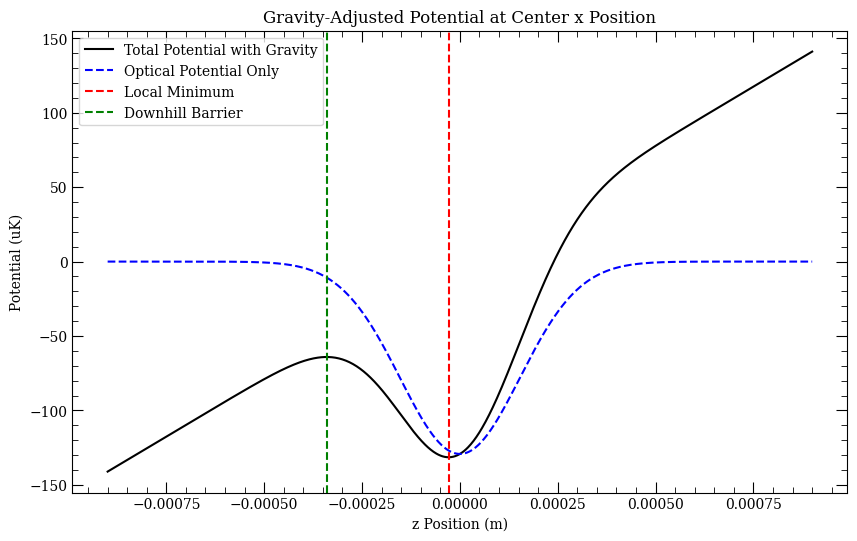

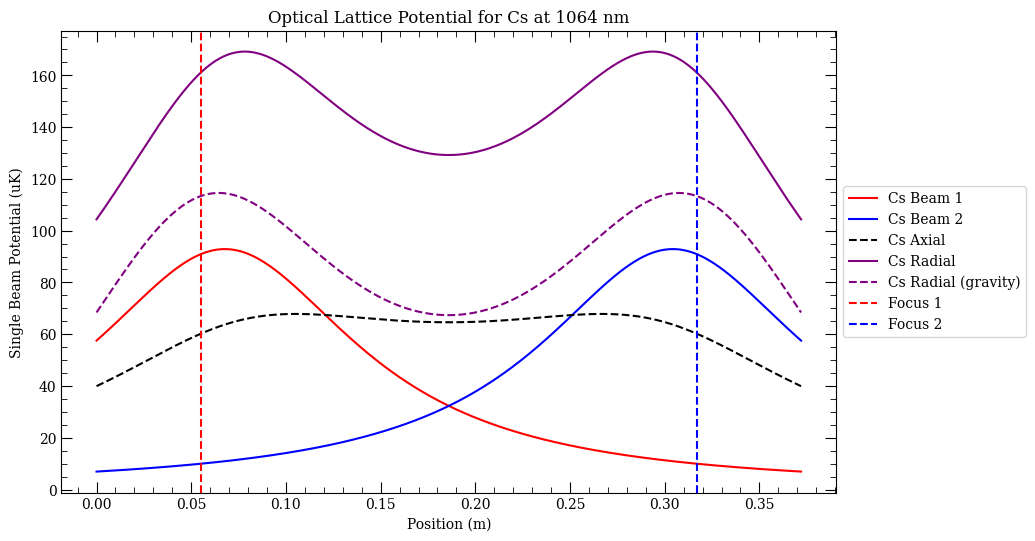

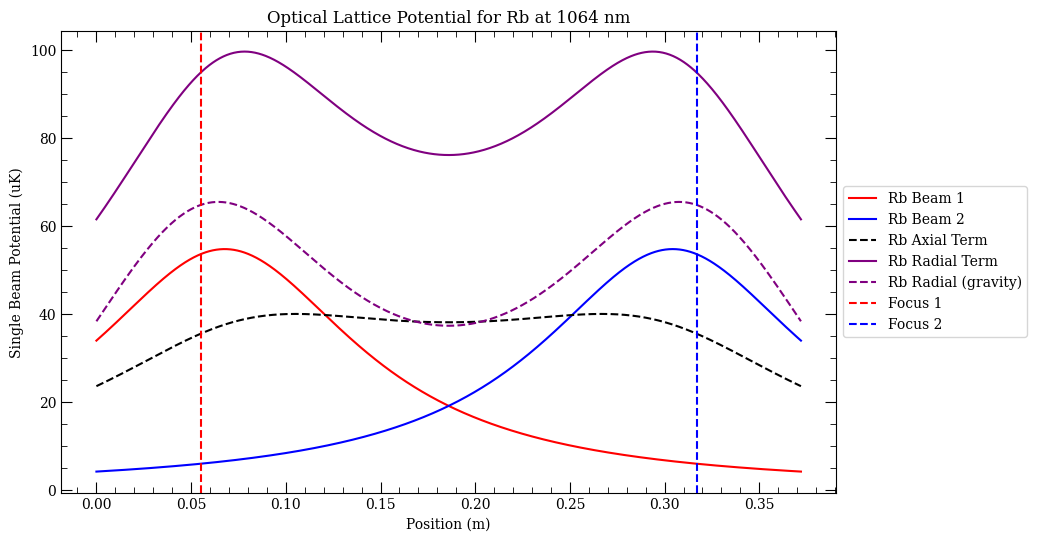

In [9]:
# now find the radial trap depth along the transport axis including gravity effects
power = 18 # power per beam in Watts
waist = 180e-6 # beam waist in meters
start_pos = 0.0
stop_pos = 0.372
focus1 = start_pos + 0.055
focus2 = stop_pos - 0.055
pos_array = np.array((np.linspace(start_pos, stop_pos, 1000),   # x positions
                    np.zeros(1000),  # y positions
                    np.zeros(1000))) # z positions

## first calculate the potential created by each beam separately
U1_Cs = odt_depth(I1, alpha_Cs_SI) * 1e6  # convert to uK
U2_Cs = odt_depth(I2, alpha_Cs_SI) * 1e6  # convert to uK
# calculate the cross term potential (axial)
U_cross_Cs = odt_depth(np.sqrt(I1*I2), alpha_Cs_SI) * 1e6  # convert to uK
# calculate the radial potential
U_radial_Cs = odt_depth(I1+I2+2*np.sqrt(I1*I2), alpha_Cs_SI) * 1e6  # convert to uK
depth_Cs_uK, zmin_Cs, Umin_Cs, Ubar_Cs = radial_trap_depth_vs_x_with_gravity(
    x_array=pos_array[0],
    P=power, w0=waist,
    focus1=focus1, focus2=focus2,
    wavelength=wavelength,
    alpha_SI=alpha_Cs_SI,
    mass_kg=Cesium().mass,
    z_max=5*waist, Nz=1000, plot_vertical_pot=True
)

plt.figure(figsize=(10, 6))
plt.plot(pos_array[0], U1_Cs, 'r-', label='Cs Beam 1')
plt.plot(pos_array[0], U2_Cs, 'b-', label='Cs Beam 2')
plt.plot(pos_array[0], 2*U_cross_Cs, 'k--', label='Cs Axial')
plt.plot(pos_array[0], U_radial_Cs, 'purple', label='Cs Radial')
plt.plot(pos_array[0], depth_Cs_uK, 'purple', linestyle='--', label='Cs Radial (gravity)')
# plot the positions of the foci
plt.axvline(focus1, color='red', linestyle='--', label='Focus 1')
plt.axvline(focus2, color='blue', linestyle='--', label='Focus 2')
plt.xlabel('Position (m)')
plt.ylabel('Single Beam Potential (uK)')
# put legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Optical Lattice Potential for Cs at 1064 nm')
plt.show()


# repeat for Rb
U1_Rb = odt_depth(I1, alpha_Rb_SI) * 1e6  # convert to uK
U2_Rb = odt_depth(I2, alpha_Rb_SI) * 1e6  # convert to uK
# calculate the cross term potential (axial)
U_cross_Rb = odt_depth(np.sqrt(I1*I2), alpha_Rb_SI) * 1e6  # convert to uK
# calculate the radial potential
U_radial_Rb = odt_depth(I1+I2+2*np.sqrt(I1*I2), alpha_Rb_SI) * 1e6  # convert to uK
depth_Rb_uK, zmin_Rb, Umin_Rb, Ubar_Rb = radial_trap_depth_vs_x_with_gravity(
    x_array=pos_array[0],
    P=power, w0=waist,
    focus1=focus1, focus2=focus2,
    wavelength=wavelength,
    alpha_SI=alpha_Rb_SI,
    mass_kg=Rubidium().mass,
    z_max=5*waist, Nz=1000
)
plt.figure(figsize=(10, 6))
plt.plot(pos_array[0], U1_Rb, 'r-', label='Rb Beam 1')
plt.plot(pos_array[0], U2_Rb, 'b-', label='Rb Beam 2')
plt.plot(pos_array[0], 2*U_cross_Rb, 'k--', label='Rb Axial Term')
plt.plot(pos_array[0], U_radial_Rb, 'purple', label='Rb Radial Term')
plt.plot(pos_array[0], depth_Rb_uK, 'purple', linestyle='--', label='Rb Radial (gravity)')
# plot the positions of the foci
plt.axvline(focus1, color='red', linestyle='--', label='Focus 1')
plt.axvline(focus2, color='blue', linestyle='--', label='Focus 2')
plt.xlabel('Position (m)')
plt.ylabel('Single Beam Potential (uK)')
# put legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Optical Lattice Potential for Rb at 1064 nm')
plt.show()

## Sweeping power and distance now. (with gravity)

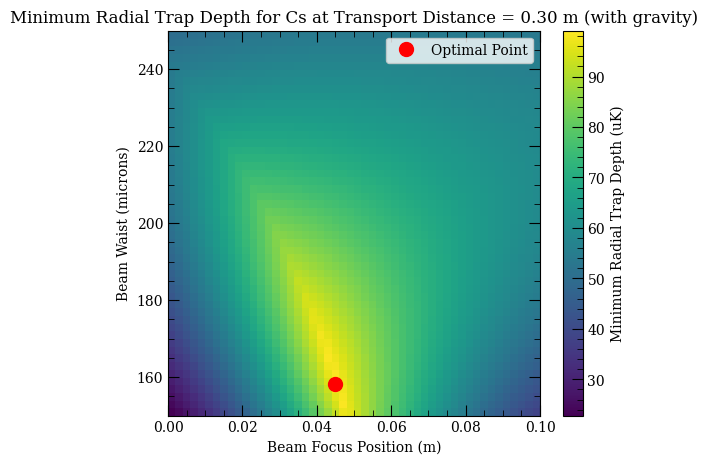

Completed transport distance = 0.30 m


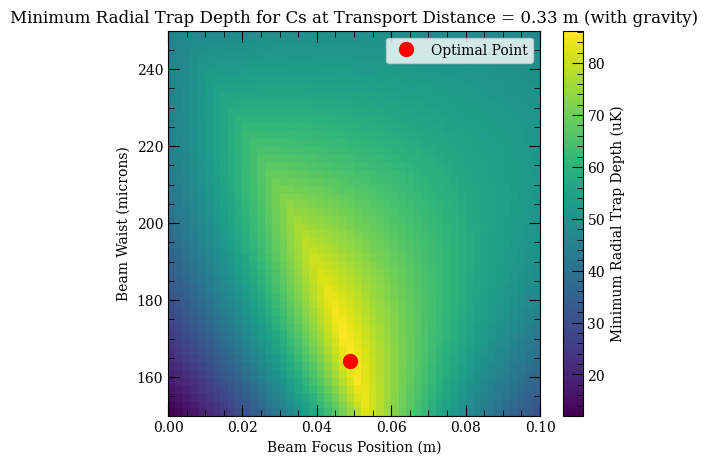

Completed transport distance = 0.33 m


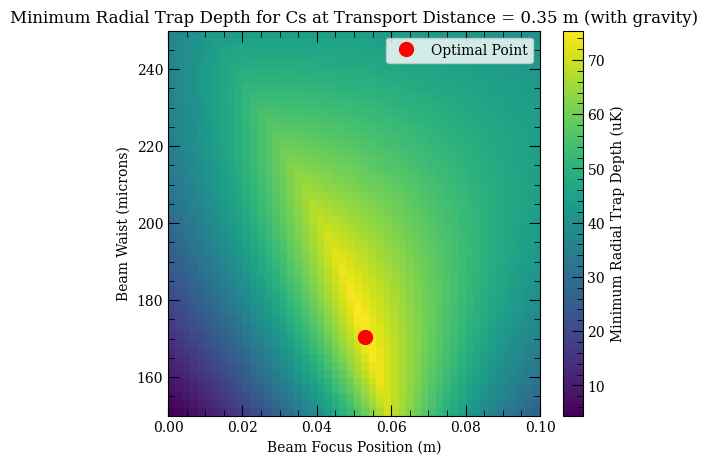

Completed transport distance = 0.35 m


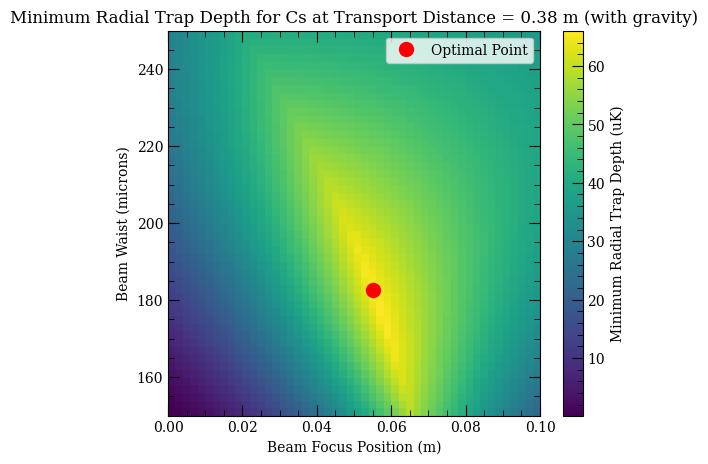

Completed transport distance = 0.38 m


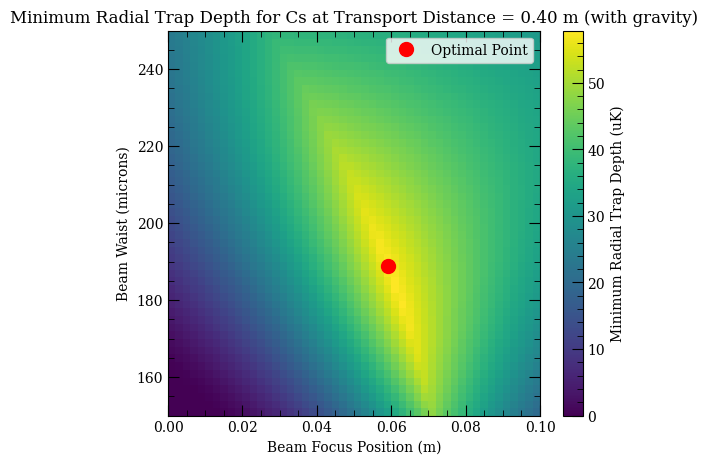

Completed transport distance = 0.40 m


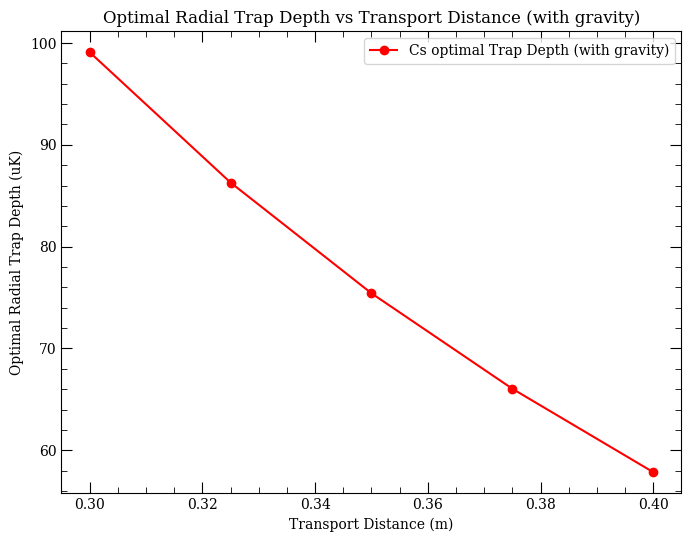

In [84]:
# first sweeping over transport distance again to find optimal parameters including gravity effects

transport_distances = np.linspace(0.3, 0.4, 5)  # transport distances
cs_data_array = []
plot_heatmap = True
for dist in transport_distances:
    # now 2D sweep of beam waist and beam focus positions
    # the start and stop of the atoms is always 0.0 and dist
    # the focus positions will always be symmetric around the center point dist/2
    start_pos = 0.0
    stop_pos = dist
    center_pos = (start_pos + stop_pos) / 2
    focus_array = np.linspace(0.0, 0.1, 50)  # focus positions from 0 to center position
    waist_array = np.linspace(150e-6, 250e-6, 50)  # beam waist

    # for the sweep, we find the minimum radial trap depth between the start and stop positions
    min_trap_depth_Cs = []

    pos_array = np.array((np.linspace(start_pos, stop_pos, 100),   # x positions
                        np.zeros(100),  # y positions
                        np.zeros(100))) # z positions

    for waist in waist_array:
        temp_depths_Cs = []

        for focus in focus_array:
            depth_Cs_uK, _, _, _ = radial_trap_depth_vs_x_with_gravity(
                x_array=pos_array[0],
                P=power, w0=waist,
                focus1=focus, focus2=stop_pos - focus,
                wavelength=wavelength,
                alpha_SI=alpha_Cs_SI,
                mass_kg=Cesium().mass,
                z_max=5*waist, Nz=100
            )
            
           # find the minimum radial trap depth for each beam
            min_depth_Cs = np.min(depth_Cs_uK)

            temp_depths_Cs.append(min_depth_Cs)

        # find the minimum trap depth
        min_trap_depth_Cs.append(temp_depths_Cs)

    cs_data_array.append(min_trap_depth_Cs)

    if plot_heatmap:
        # plot the 2D heatmap for this transport distance
        plt.figure(figsize=(6, 5))
        plt.imshow(min_trap_depth_Cs, extent=(focus_array[0], focus_array[-1], waist_array[0]*1e6, waist_array[-1]*1e6), aspect='auto', origin='lower', cmap='viridis')
        plt.colorbar(label='Minimum Radial Trap Depth (uK)')
        plt.ylabel('Beam Waist (microns)')
        plt.xlabel('Beam Focus Position (m)')
        plt.title(f'Minimum Radial Trap Depth for Cs at Transport Distance = {dist:.2f} m (with gravity)')
        # put a red dot at the optimal waist and focus
        min_trap_depth_Cs = np.array(min_trap_depth_Cs)
        opt_params_Cs = np.unravel_index(np.argmax(min_trap_depth_Cs, axis=None), min_trap_depth_Cs.shape)
        plt.plot(focus_array[opt_params_Cs[1]], waist_array[opt_params_Cs[0]]*1e6, 'ro', markersize=10, label='Optimal Point')
        plt.legend()
        plt.show()
    print(f"Completed transport distance = {dist:.2f} m")

# convert to numpy arrays
cs_data_array = np.array(cs_data_array)

# plot the maximum trap depth as a function of transport distance
max_trap_depths_Cs = [np.max(data) for data in cs_data_array]
plt.figure(figsize=(8, 6))
plt.plot(transport_distances, max_trap_depths_Cs, 'r-o', label='Cs optimal Trap Depth (with gravity)')
plt.xlabel('Transport Distance (m)')
plt.ylabel('Optimal Radial Trap Depth (uK)')
plt.title('Optimal Radial Trap Depth vs Transport Distance (with gravity)')
plt.legend()
plt.show()

In [85]:
# find optimal parameters at each transport distance
optimal_waists_Cs = []
optimal_focuses_Cs = []
for i, dist in enumerate(transport_distances):
    min_trap_depth_Cs = np.array(cs_data_array[i])
    opt_params_Cs = np.unravel_index(np.argmax(min_trap_depth_Cs, axis=None), min_trap_depth_Cs.shape)
    optimal_waists_Cs.append(waist_array[opt_params_Cs[0]])
    optimal_focuses_Cs.append(focus_array[opt_params_Cs[1]])

print("Optimal parameters including gravity effects:")
for i, dist in enumerate(transport_distances):
    print(f"At transport distance = {dist:.2f} m: Waist = {optimal_waists_Cs[i]*1e6:.2f} microns, Focus = {optimal_focuses_Cs[i]:.4f} m, Max Trap Depth = {max_trap_depths_Cs[i]:.2f} uK")

Optimal parameters including gravity effects:
At transport distance = 0.30 m: Waist = 158.16 microns, Focus = 0.0449 m, Max Trap Depth = 99.10 uK
At transport distance = 0.33 m: Waist = 164.29 microns, Focus = 0.0490 m, Max Trap Depth = 86.30 uK
At transport distance = 0.35 m: Waist = 170.41 microns, Focus = 0.0531 m, Max Trap Depth = 75.42 uK
At transport distance = 0.38 m: Waist = 182.65 microns, Focus = 0.0551 m, Max Trap Depth = 66.04 uK
At transport distance = 0.40 m: Waist = 188.78 microns, Focus = 0.0592 m, Max Trap Depth = 57.85 uK


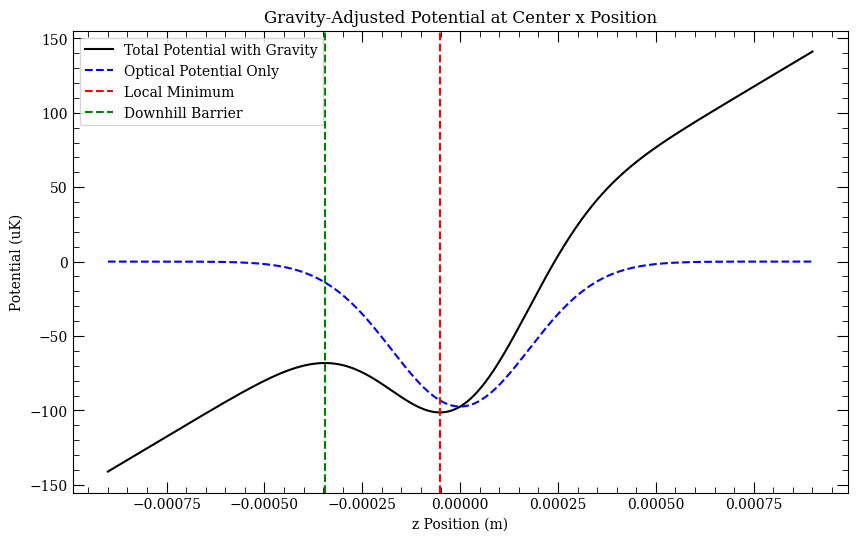

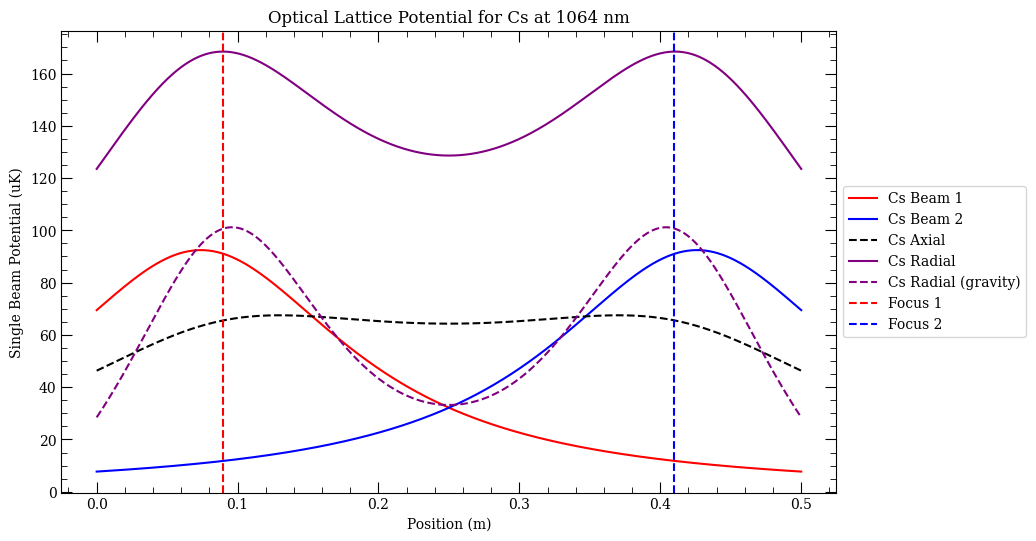

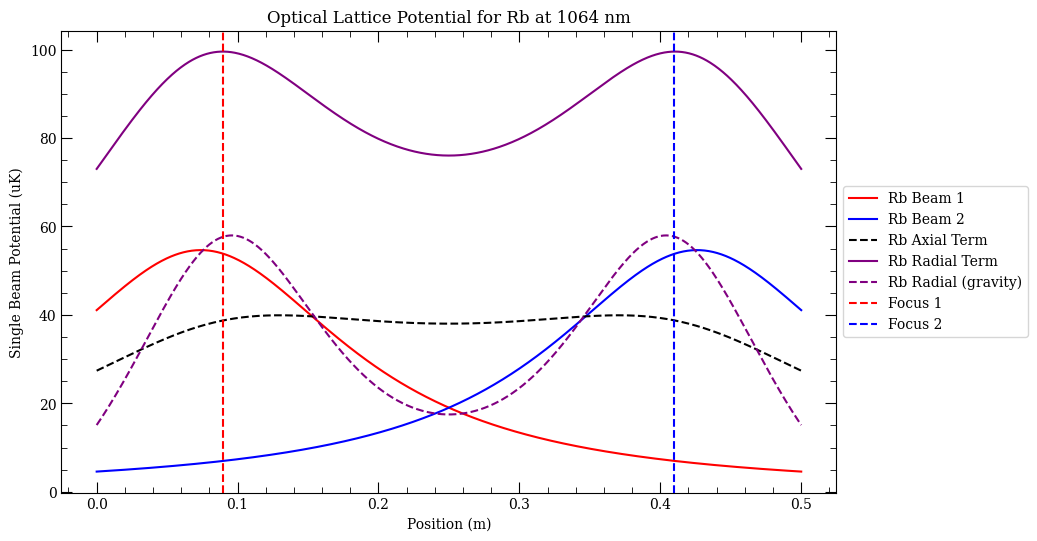

In [ ]:
# now find the radial trap depth along the transport axis including gravity effects
power = 18 # power per beam in Watts
waist = 180e-6 # beam waist in meters
start_pos = 0.0
stop_pos = 0.5
focus1 = start_pos + 0.09
focus2 = stop_pos - 0.09
pos_array = np.array((np.linspace(start_pos, stop_pos, 1000),   # x positions
                    np.zeros(1000),  # y positions
                    np.zeros(1000))) # z positions

## first calculate the potential created by each beam separately
U1_Cs = odt_depth(I1, alpha_Cs_SI) * 1e6  # convert to uK
U2_Cs = odt_depth(I2, alpha_Cs_SI) * 1e6  # convert to uK
# calculate the cross term potential (axial)
U_cross_Cs = odt_depth(np.sqrt(I1*I2), alpha_Cs_SI) * 1e6  # convert to uK
# calculate the radial potential
U_radial_Cs = odt_depth(I1+I2+2*np.sqrt(I1*I2), alpha_Cs_SI) * 1e6  # convert to uK
depth_Cs_uK, zmin_Cs, Umin_Cs, Ubar_Cs = radial_trap_depth_vs_x_with_gravity(
    x_array=pos_array[0],
    P=power, w0=waist,
    focus1=focus1, focus2=focus2,
    wavelength=wavelength,
    alpha_SI=alpha_Cs_SI,
    mass_kg=Cesium().mass,
    z_max=5*waist, Nz=1000, plot_vertical_pot=False
)

plt.figure(figsize=(10, 6))
plt.plot(pos_array[0], U1_Cs, 'r-', label='Cs Beam 1')
plt.plot(pos_array[0], U2_Cs, 'b-', label='Cs Beam 2')
plt.plot(pos_array[0], 2*U_cross_Cs, 'k--', label='Cs Axial')
plt.plot(pos_array[0], U_radial_Cs, 'purple', label='Cs Radial')
plt.plot(pos_array[0], depth_Cs_uK, 'purple', linestyle='--', label='Cs Radial (gravity)')
# plot the positions of the foci
plt.axvline(focus1, color='red', linestyle='--', label='Focus 1')
plt.axvline(focus2, color='blue', linestyle='--', label='Focus 2')
plt.xlabel('Position (m)')
plt.ylabel('Single Beam Potential (uK)')
# put legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Optical Lattice Potential for Cs at 1064 nm')
plt.show()


# repeat for Rb
U1_Rb = odt_depth(I1, alpha_Rb_SI) * 1e6  # convert to uK
U2_Rb = odt_depth(I2, alpha_Rb_SI) * 1e6  # convert to uK
# calculate the cross term potential (axial)
U_cross_Rb = odt_depth(np.sqrt(I1*I2), alpha_Rb_SI) * 1e6  # convert to uK
# calculate the radial potential
U_radial_Rb = odt_depth(I1+I2+2*np.sqrt(I1*I2), alpha_Rb_SI) * 1e6  # convert to uK
depth_Rb_uK, zmin_Rb, Umin_Rb, Ubar_Rb = radial_trap_depth_vs_x_with_gravity(
    x_array=pos_array[0],
    P=power, w0=waist,
    focus1=focus1, focus2=focus2,
    wavelength=wavelength,
    alpha_SI=alpha_Rb_SI,
    mass_kg=Rubidium().mass,
    z_max=5*waist, Nz=1000
)
plt.figure(figsize=(10, 6))
plt.plot(pos_array[0], U1_Rb, 'r-', label='Rb Beam 1')
plt.plot(pos_array[0], U2_Rb, 'b-', label='Rb Beam 2')
plt.plot(pos_array[0], 2*U_cross_Rb, 'k--', label='Rb Axial Term')
plt.plot(pos_array[0], U_radial_Rb, 'purple', label='Rb Radial Term')
plt.plot(pos_array[0], depth_Rb_uK, 'purple', linestyle='--', label='Rb Radial (gravity)')
# plot the positions of the foci
plt.axvline(focus1, color='red', linestyle='--', label='Focus 1')
plt.axvline(focus2, color='blue', linestyle='--', label='Focus 2')
plt.xlabel('Position (m)')
plt.ylabel('Single Beam Potential (uK)')
# put legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Optical Lattice Potential for Rb at 1064 nm')
plt.show()

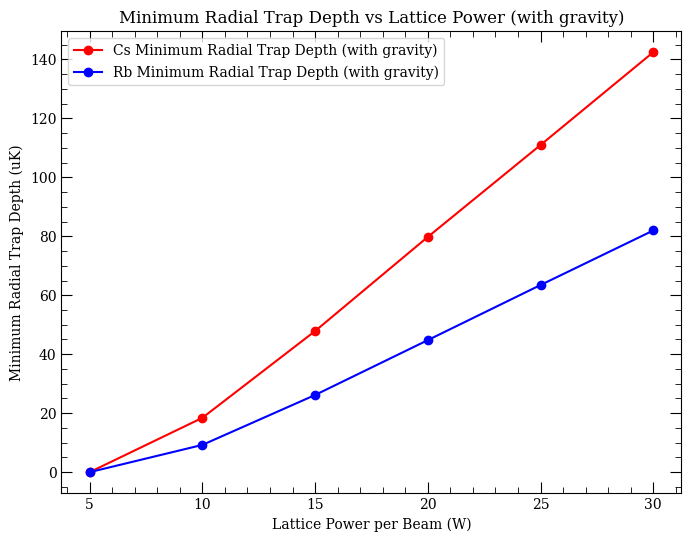

In [86]:
start_pos = 0.0
stop_pos = 0.372
pos_array = np.array((np.linspace(start_pos, stop_pos, 100),   # x positions
                    np.zeros(100),  # y positions
                    np.zeros(100))) # z positions
waist = 180e-6 # beam waist in meters
focus1 = start_pos + 0.055
focus2 = stop_pos - 0.055

# sweep over the lattice power to see effect on trap depth including gravity
power_array = np.linspace(5, 30, 6)  # power per beam
depths_Cs_vs_power = []
depths_Rb_vs_power = []
for power in power_array:
    depth_Cs_uK, _, _, _ = radial_trap_depth_vs_x_with_gravity(
        x_array=pos_array[0],
        P=power, w0=waist,
        focus1=focus1, focus2=focus2,
        wavelength=wavelength,
        alpha_SI=alpha_Cs_SI,
        mass_kg=Cesium().mass,
        z_max=5*waist, Nz=1000
    )
    depth_Rb_uK, _, _, _ = radial_trap_depth_vs_x_with_gravity(
        x_array=pos_array[0],
        P=power, w0=waist,
        focus1=focus1, focus2=focus2,
        wavelength=wavelength,
        alpha_SI=alpha_Rb_SI,
        mass_kg=Rubidium().mass,
        z_max=5*waist, Nz=1000
    )
    depths_Cs_vs_power.append(np.min(depth_Cs_uK))
    depths_Rb_vs_power.append(np.min(depth_Rb_uK))

plt.figure(figsize=(8, 6))
plt.plot(power_array, depths_Cs_vs_power, 'r-o', label='Cs Minimum Radial Trap Depth (with gravity)')
plt.plot(power_array, depths_Rb_vs_power, 'b-o', label='Rb Minimum Radial Trap Depth (with gravity)')
plt.xlabel('Lattice Power per Beam (W)')
plt.ylabel('Minimum Radial Trap Depth (uK)')
plt.title('Minimum Radial Trap Depth vs Lattice Power (with gravity)')
plt.legend()
plt.show()